In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import healpy as hp
from scipy.interpolate import interp1d
import scipy.signal as signal

nside = 1024
lmax = 1024*3-1

# Load data

In [2]:
std_ellipticity1 = 0.18011215 # This comes from Buzzard
full_data = fits.open('data/KS_1024.fits')
full_data.info()
full_data[1].columns

Filename: data/KS_1024.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     32   12582912R x 12C   [D, D, D, D, D, D, D, D, D, D, D, D]   


ColDefs(
    name = 'KS_E'; format = 'D'
    name = 'KS_E_noise'; format = 'D'
    name = 'KS_E_noise_only'; format = 'D'
    name = 'KS_B'; format = 'D'
    name = 'KS_B_noise'; format = 'D'
    name = 'KS_B_noise_only'; format = 'D'
    name = 'E1'; format = 'D'
    name = 'E2'; format = 'D'
    name = 'G2'; format = 'D'
    name = 'G1'; format = 'D'
    name = 'k_orig'; format = 'D'
    name = 'N_source'; format = 'D'
)

In [3]:
mask = np.load('data/masks.pkl',allow_pickle=True)[1024]

In [4]:
des_count_map = hp.ud_grade(full_data[1].data['N_source'], nside, power=-2)
des_count_map = des_count_map*mask

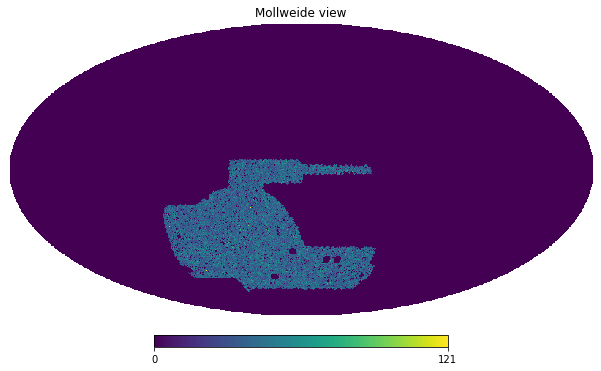

In [5]:
hp.mollview(des_count_map)

In [6]:
footprint_mask = np.where(hp.ud_grade(full_data[1].data['N_source'], nside, power=-2)>0.5,1.,0.)

In [7]:
mask_des = np.where(des_count_map>0.5,1.,0.)
mask_des = np.array([mask_des,mask_des])

In [8]:
hp.write_map('mask_des1024_QU.fits', mask_des, overwrite=True)

In [9]:
gamma1 = hp.ud_grade(full_data[1].data['E1'],nside)*mask
gamma2 = hp.ud_grade(full_data[1].data['E2'],nside)*mask

In [10]:
map_mock_des_QU = np.array([gamma1, gamma2])

In [11]:
hp.write_map('map_mock_des1024_QU.fits', map_mock_des_QU, overwrite=True)

# Noise covariance

In [12]:
# Variance of ellipicity component for a single galaxy
e1_var = std_ellipticity1*std_ellipticity1

In [13]:
# Define 1e10 as "infinity"
noise_cov_des = np.ones(map_mock_des_QU.shape)*1e10

## QQ noise
noise_cov_des[0,:] = np.where(des_count_map>0.5,e1_var/des_count_map, noise_cov_des[1,:])

## UU noise
noise_cov_des[1,:] = np.where(des_count_map>0.5,e1_var/des_count_map, noise_cov_des[1,:])

/Users/ucapnje/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/ucapnje/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/Users/ucapnje/anaconda3/lib/python3.6/site-packages/healpy/projector.py:846: RuntimeWarning: invalid value encountered in greater
  mask = np.asarray(x) ** 2 + np.asarray(y) ** 2 > 1.0
/Users/ucapnje/anaconda3/lib/python3.6/site-packages/healpy/projaxes.py:423: RuntimeWarning: invalid value encountered in greater
  w = np.where(d2 > threshold)[0]


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


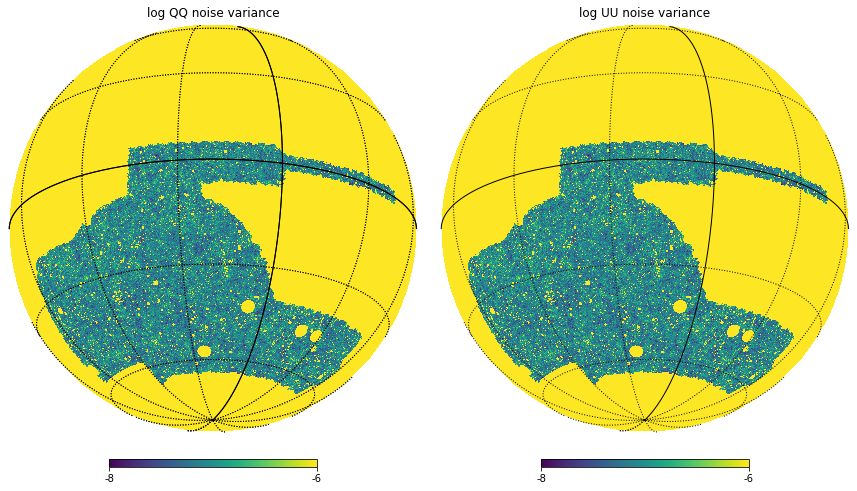

In [14]:
_ = plt.figure(figsize=(12,7))
_ = hp.orthview(np.log(noise_cov_des[0,:]),
            min=-8,max=-6, rot=(20,-20,0) , half_sky=True, sub=(1,2,1),
               title='log QQ noise variance'), hp.graticule()

_ = hp.orthview(np.log(noise_cov_des[1,:]),
            min=-8,max=-6, rot=(20,-20,0) , half_sky=True, sub=(1,2,2),
               title='log UU noise variance'), hp.graticule()

In [15]:
hp.write_map('map_noise_cov_des1024_QU.fits', noise_cov_des, overwrite=True)

# Power spectrum 

In [16]:
# load namaster calculated power 
namaster_pseudo_power = np.load('./data/namaster_buzzard.npy')
ell_pseudo = namaster_pseudo_power[0]
Cell_pseudo = namaster_pseudo_power[1]

In [17]:
# Check power compared to anafast + fsky approximation
cl = hp.anafast(hp.ud_grade(full_data[1].data['k_orig'], nside, power=-2), lmax=lmax)
ell = np.arange(len(cl))

f_sky = float(np.where(footprint_mask>0.5)[0].shape[0])/float(mask_des[0].shape[0])
print(f_sky)
cl = cl/f_sky

0.12608798344930014


In [18]:
filtered_cl = np.exp(signal.savgol_filter(np.log(cl), 95, 5))

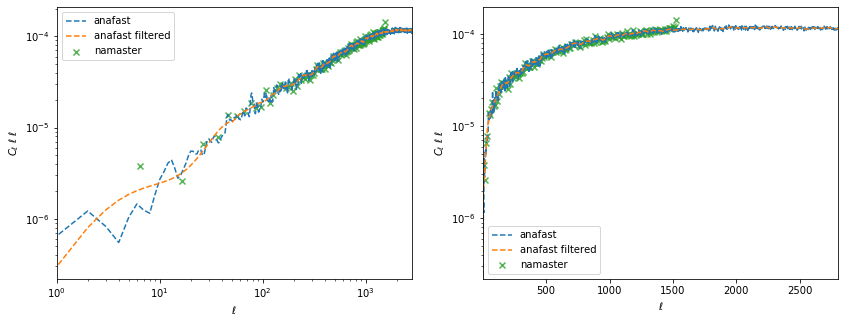

In [19]:
_ = plt.figure(figsize = (14,5))
_ = plt.subplot(1,2,1)
_ = plt.loglog(ell,cl*ell*ell, '--', label='anafast')
_ = plt.loglog(ell,filtered_cl*ell*ell, '--', label='anafast filtered')
_ = plt.scatter(ell_pseudo,Cell_pseudo*ell_pseudo*ell_pseudo, marker='x', alpha = 0.8,label='namaster', c='C2')
_ = plt.ylabel(r'$C_\ell\ \ell \ \ell$'), plt.xlabel(r'$\ell$')
_ = plt.xlim(1,2800), plt.legend()
_ = plt.subplot(1,2,2)
_ = plt.plot(ell,cl*ell*ell, '--', label='anafast')
_ = plt.plot(ell,filtered_cl*ell*ell, '--', label='anafast filtered')
_ = plt.scatter(ell_pseudo,Cell_pseudo*ell_pseudo*ell_pseudo, marker='x', alpha = 0.8,label='namaster', c='C2')
_ = plt.ylabel(r'$C_\ell\ \ell \ \ell$'), plt.xlabel(r'$\ell$')
_ = plt.xlim(1,2800), plt.legend()
_ = plt.yscale('log')

In [20]:
np.save('anafast_buzzard',np.vstack([ell,cl]))
np.save('anafast_filtered_buzzard',np.vstack([ell,filtered_cl]))

# Signal covariance

In [21]:
cell_func_filtered_anafast = interp1d(np.hstack([ell, [ell[-1]+1,1e4]]),
                     np.hstack([filtered_cl, [filtered_cl[-10]*0.5,1e-15]]),
                     fill_value='extrapolate', kind='linear')

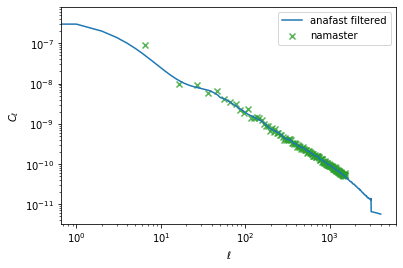

In [22]:
_ = plt.loglog(np.arange(0,4000), cell_func_filtered_anafast(np.arange(0,4000)),label='anafast filtered')
_ = plt.scatter(ell_pseudo,Cell_pseudo, marker='x', alpha = 0.8,label='namaster', c='C2')
_ = plt.ylabel(r'$C_\ell  \ $'), plt.xlabel(r'$\ell$')
_ = plt.legend()

In [23]:
ell_cov, mmm_cov = hp.Alm.getlm(nside*3-1)
s_cov_EE_diag =  cell_func_filtered_anafast(ell_cov)

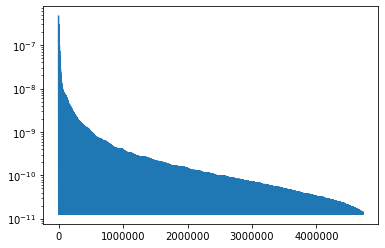

In [24]:
_ = plt.plot(s_cov_EE_diag), plt.yscale('log')

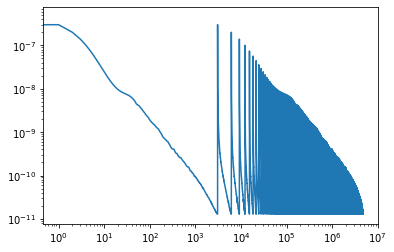

In [25]:
_ = plt.loglog(s_cov_EE_diag)

In [26]:
np.save('s_cov_EE_1024',s_cov_EE_diag)